# Independent Expenditures
## What is an Independent Expenditure?
According to the <a href='https://www.fec.gov/help-candidates-and-committees/making-disbursements-pac/independent-expenditures-nonconnected-pac/'> Federal Election Commission documentation</a>, an Independent Expenditure is an expenditure for a communication that 'expressly advocates the election or defeat of a clearly identified federal candidate; and is not coordinated with a candidate, candidate’s committee, party committee or their agents.'
## What's the data going to tell us?

The FEC data will be able to tell us a variety of things about a given election year.  Below, we will quantify:
- Number of communications advocating for a given candidate
- Number of communications advocating against a given candidate
- Total cost of the communications for or against a given candidates
- Those candidates a committee has spent money for or against
- The sum of money a given committee has spent for or against a candidate


# The Data
Raw data is obtained from the <a href=https://cg-519a459a-0ea3-42c2-b7bc-fa1143481f74.s3-us-gov-west-1.amazonaws.com/bulk-downloads/index.html> Federal Election Commission bulk data sources </a>.  This notebook primarily uses the 'independent_expenditures' csv files located in the annual subfolders; i.e. 2016/independent_expenditures_2016.csv

In [4]:
# Import dependencies
# Basic modules
import re
import datetime
from operator import add

# Data analysis modules
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Instantiate variables for processing data moving forward
spark = SparkSession.builder.appName('ElectionAnalyzer').getOrCreate()
datapath = '/Users/Dan/Downloads/'
# Set the election year; modify this value to look at a different year
election_year = "2016"
# Set the file paths for the data file, based on the data path and election year
independent_expenditure_file = '{0}independent_expenditure_{1}.csv'.format(datapath, election_year)

In [6]:
# Read each data file from CSV as a spark dataframe
ind_exp = spark.read.csv(independent_expenditure_file, header=True)

In [7]:
# Convert the dataframe with headers to an RDD, for use in map/reduce actions
total_expenditures_rdd = (
    ind_exp
    .rdd
    .filter(lambda x: len(x) != 0)
)

total_expenditures_dataframe = (
    ind_exp
    .rdd
    .filter(lambda x: x.exp_amo)
    .filter(lambda x: x.exp_date)
    .map(lambda x: (float(x.exp_amo), datetime.datetime.strptime(x.exp_date, '%d-%b-%y')))
    .toDF()
    .toPandas()
)

#total_expenditures_dataframe = total_expenditures_dataframe.agg_amo.astype(float)
total_expenditures_dataframe.columns = ['expenditure','date']

print (total_expenditures_dataframe.head(5))

   expenditure       date
0     188000.0 2016-11-07
1      50359.0 2016-10-26
2     100000.0 2016-10-28
3      22000.0 2016-11-03
4      68240.0 2016-11-03


In [8]:
# Print the first expenditures RDD -- this is for general debugging and viewing
total_expenditures_rdd.first()

Row(cand_id='P00003392', cand_name='CLINTON, HILLARY RODHAM', spe_id='C00344531', spe_nam='1199 32BJ/144 SERVICE EMPLOYEES INTERNATIONAL UNION HOME CARE POLITICAL ACTION FUND', ele_type='G', can_office_state=None, can_office_dis='00', can_office='P', cand_pty_aff='DEMOCRATIC PARTY', exp_amo='188000', exp_date='07-NOV-16', agg_amo='188000', sup_opp='S', pur='EVENT EXPENSES', pay='ART SCHOOL DROPOUT INC.', file_num='1123839', amndt_ind='N', tran_id='SE.5047', image_num='201611049037122225', receipt_dat='04-NOV-16', fec_election_yr='2016', prev_file_num=None)

In [9]:
# Return an list of (total number of expenditures, Candidate Name)
# sorted by total number of expenditures related to that candidate
def aggregate_sup_or_opp_expenditures(sup_or_opp):
    sup_or_opp_expenditures = (
        total_expenditures_rdd
        .filter(lambda x: x.sup_opp == '{}'.format(sup_or_opp))
        .map(lambda x: ((x.cand_name).upper(), 1))
        .reduceByKey(add)
        .map(lambda x: (x[1], x[0]))
        .sortByKey(False)
    )
    return sup_or_opp_expenditures

supportive_expenditures_by_candidate = aggregate_sup_or_opp_expenditures('S')
oppositional_expenditures_by_candidate = aggregate_sup_or_opp_expenditures('O')


In [10]:
# Print to the console a list containing tuples of (count of supportive expenditures, candidate names)
print(supportive_expenditures_by_candidate.collect())

[(39523, 'CLINTON, HILLARY'), (16440, 'STRICKLAND, TED'), (9572, 'ROSS, DEBORAH'), (7577, 'MCGINTY, KATHLEEN'), (3316, 'MURPHY, PATRICK'), (3297, 'KANDER, JASON'), (1979, 'CLINTON, HILLARY RODHAM'), (885, 'TRUMP, DONALD'), (820, 'DUCKWORTH, TAMMY'), (682, 'RUBIO, MARCO'), (673, 'BUSH, JEB'), (671, 'CHRISTIE, CHRISTOPHER J.'), (574, "CRUZ, RAFAEL EDWARD 'TED'"), (572, 'SANDERS, BERNARD'), (497, 'CARSON, BEN'), (452, 'BAYH, EVAN'), (403, 'SANDERS, BERNIE'), (398, 'CRUZ, TED'), (307, 'MASTO, CATHERINE CORTEZ'), (257, 'GLENN, DARRYL'), (242, "CRUZ, RAFAEL 'TED'"), (223, 'JOHNSON, RON'), (198, 'TRUMP, DONALD J'), (191, 'MCGINTY, KATIE'), (185, 'RODHAM CLINTON, HILLARY'), (181, 'KASICH, JOHN R'), (177, 'CRUZ, RAFAEL EDWARD TED'), (172, 'CORTEZ MASTO, CATHERINE'), (168, 'MCGINTY, KATHLEEN ALANA'), (153, 'HECK, JOE'), (153, 'PAUL, RAND'), (149, 'FIORINA, CARLY'), (148, 'FEINGOLD, RUSS'), (119, 'PORTMAN, ROB'), (117, 'HASSAN, MARGARET WOOD'), (113, 'LEE, MIKE'), (110, 'LOVE, MIA'), (105, 'TRUMP

In [11]:
# Print to the console a list containing tuples of (count of oppositional expenditures, candidate names)
print(oppositional_expenditures_by_candidate.collect())

[(27648, 'TRUMP, DONALD'), (12715, 'PORTMAN, ROB'), (8801, 'BURR, RICHARD'), (2663, 'TOOMEY, PATRICK'), (2476, 'CLINTON, HILLARY RODHAM'), (1997, 'TRUMP, DONALD J.'), (1634, 'BLUNT, ROY'), (1432, 'RUBIO, MARCO'), (1229, 'CLINTON, HILLARY'), (853, 'TRUMP, DONALD J'), (811, 'KIRK, MARK'), (472, 'YOUNG, TODD'), (362, 'STRICKLAND, TED'), (322, 'BAYH, EVAN'), (288, 'MCGINTY, KATHLEEN ALANA'), (278, 'KANDER, JASON'), (255, 'HECK, JOE'), (213, 'MURPHY, PATRICK E'), (197, 'FEINGOLD, RUSSELL DANA'), (189, 'MASTO, CATHERINE CORTEZ'), (186, 'AYOTTE, KELLY'), (175, 'ROSS, DEBORAH K'), (166, 'CORTEZ MASTO, CATHERINE'), (152, 'TOOMEY, PAT'), (152, 'CARROLL, MORGAN'), (122, 'MASTO, CATHERINE'), (117, 'HECK, JOSEPH'), (116, 'MCGINTY, KATHLEEN'), (106, 'HURD, WILLIAM'), (99, "CRUZ, RAFAEL EDWARD 'TED'"), (98, 'GARRETT, SCOTT'), (88, 'POLIQUIN, BRUCE'), (83, 'COMSTOCK, BARBARA'), (80, 'MILLS, STEWART'), (79, 'TARKANIAN, DANNY'), (75, 'TOOMEY, PATRICK JOSEPH'), (72, 'KNIGHT, STEVE'), (71, 'FITZPATRICK, B

In [12]:
# Return a list of ((supportive expenditures, oppositional expenditures), CandidateName)
# Sorted by greatest number of supportive expenditures

def reduce_sup_or_opp(val):
    ''' Function to convert the sup_opp values from the FEC data
        into a tuple, so that we can then reduce it by key
        and get a consolidated view of support and oppositions in 
        one function (as opposed to the above cell, which requires two 
        executions of the same function)
    ''' 
    if val == 'S':
        return (1,0)
    if val == 'O':
        return (0,1)
    return (0,0)

sup_or_opp_expenditures = (
    total_expenditures_rdd
    .map(lambda x: ((x.cand_name).upper(), reduce_sup_or_opp(x.sup_opp)))
    .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))
    .map(lambda x: (x[1], x[0]))
    .sortByKey(False)
)

print(sup_or_opp_expenditures.collect())

[((39523, 1229), 'CLINTON, HILLARY'), ((16440, 362), 'STRICKLAND, TED'), ((9572, 61), 'ROSS, DEBORAH'), ((7577, 116), 'MCGINTY, KATHLEEN'), ((3316, 34), 'MURPHY, PATRICK'), ((3297, 278), 'KANDER, JASON'), ((1979, 2476), 'CLINTON, HILLARY RODHAM'), ((885, 27648), 'TRUMP, DONALD'), ((820, 6), 'DUCKWORTH, TAMMY'), ((682, 1432), 'RUBIO, MARCO'), ((673, 60), 'BUSH, JEB'), ((671, 31), 'CHRISTIE, CHRISTOPHER J.'), ((574, 99), "CRUZ, RAFAEL EDWARD 'TED'"), ((572, 15), 'SANDERS, BERNARD'), ((497, 6), 'CARSON, BEN'), ((452, 322), 'BAYH, EVAN'), ((403, 3), 'SANDERS, BERNIE'), ((398, 29), 'CRUZ, TED'), ((307, 189), 'MASTO, CATHERINE CORTEZ'), ((257, 8), 'GLENN, DARRYL'), ((242, 0), "CRUZ, RAFAEL 'TED'"), ((223, 27), 'JOHNSON, RON'), ((198, 853), 'TRUMP, DONALD J'), ((191, 9), 'MCGINTY, KATIE'), ((185, 0), 'RODHAM CLINTON, HILLARY'), ((181, 34), 'KASICH, JOHN R'), ((177, 29), 'CRUZ, RAFAEL EDWARD TED'), ((172, 166), 'CORTEZ MASTO, CATHERINE'), ((168, 288), 'MCGINTY, KATHLEEN ALANA'), ((153, 255), '

In [13]:
# Calculate the ratio of support to opposition for a given candidate, expressed as a precentage
# Return a list of (support to opposition ratio, candidate name) sorted by support ratio
# this does not handle 0 values gracefully at the moment, whihc must be adjusted
support_ratio = (
    sup_or_opp_expenditures
    .map(
    lambda x: (
        round((x[0][0]/x[0][1])*100, 2) 
        if (x[0][0] != 0) and (x[0][1] != 0) 
        else x[0][0]-x[0][1]*100, 
        x[1])
    )
    .sortByKey(False)
    .collect()
)

print(support_ratio)

[(15691.8, 'ROSS, DEBORAH'), (13666.67, 'DUCKWORTH, TAMMY'), (13433.33, 'SANDERS, BERNIE'), (9752.94, 'MURPHY, PATRICK'), (8283.33, 'CARSON, BEN'), (6531.9, 'MCGINTY, KATHLEEN'), (4541.44, 'STRICKLAND, TED'), (4400.0, 'MAST, BRIAN'), (3813.33, 'SANDERS, BERNARD'), (3800.0, 'HILLARY, CLINTON'), (3300.0, 'HILLARY CLINTON, RUSS FEINGOLD'), (3215.87, 'CLINTON, HILLARY'), (3212.5, 'GLENN, DARRYL'), (2500.0, 'JINDAL, BOBBY'), (2433.33, 'CAMPBELL, FOSTER LONNNIE II'), (2300.0, 'CORTEZ-MASTO, CATHERINE'), (2164.52, 'CHRISTIE, CHRISTOPHER J.'), (2122.22, 'MCGINTY, KATIE'), (1900.0, 'GOTTHEIMER, JOSH'), (1800.0, 'BARRAGAN, NANETTE'), (1640.0, 'DRISKELL, GRETCHEN'), (1550.0, 'JOHNSON, GARY'), (1372.41, 'CRUZ, TED'), (1200.0, 'EDWARDS, DONNA FERN'), (1185.97, 'KANDER, JASON'), (1121.67, 'BUSH, JEB'), (966.67, 'NEGRON, REBECCA'), (950.0, 'HARRIS, KAMALA'), (931.25, 'FIORINA, CARLY'), (850.0, 'PAUL, RAND'), (850.0, 'STUTZMAN, MARLIN'), (825.93, 'JOHNSON, RON'), (825.0, 'WALKER, SCOTT'), (800.0, 'GAE

In [14]:
# Return an list of (total number of expenditures, spender name)
# sorted by total number of expenditures by that spender
expenditures_by_spender = (
    total_expenditures_rdd
    .map(lambda x: ((x.spe_nam), 1))
    .reduceByKey(add)
    .map(lambda x: (x[1], x[0]))
    .sortByKey(False)
    .collect()
)

In [15]:
print(expenditures_by_spender)

[(131187, 'Working America'), (1477, 'AMERICANS FOR PROSPERITY'), (1472, 'DCCC'), (1012, "FREEDOM'S DEFENSE FUND"), (954, 'VIGOP (VIRGIN ISLANDS REPUBLICAN PARTY)'), (929, 'Coalition of Black Trade Unionists'), (854, 'Right to Rise USA'), (852, 'Planned Parenthood Votes'), (822, 'AVAAZ FOUNDATION'), (749, 'House Majority PAC'), (721, 'NRCC'), (717, 'The 2016 Committee'), (706, 'National Rifle Association of America Political Victory Fund'), (681, 'CLUB FOR GROWTH ACTION'), (677, 'America Leads'), (663, 'FEMINIST MAJORITY'), (603, 'MOVEON.ORG POLITICAL ACTION'), (525, 'National Nurses United for Patient Protection'), (494, 'For Our Future'), (473, 'GREAT AMERICA PAC'), (469, 'Working America Coalition'), (459, 'Conservative Solutions PAC'), (457, 'Senate Majority PAC'), (448, 'SEIU COPE (Service Employees International Union Committee On Political Education)'), (399, 'Planned Parenthood Action Fund Inc.'), (386, 'LIBRE INITIATIVE'), (374, 'Immigrant Voters Win PAC'), (373, 'American Maj

/Users/Dan/Documents/projects/spark_learning/spark/spark/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


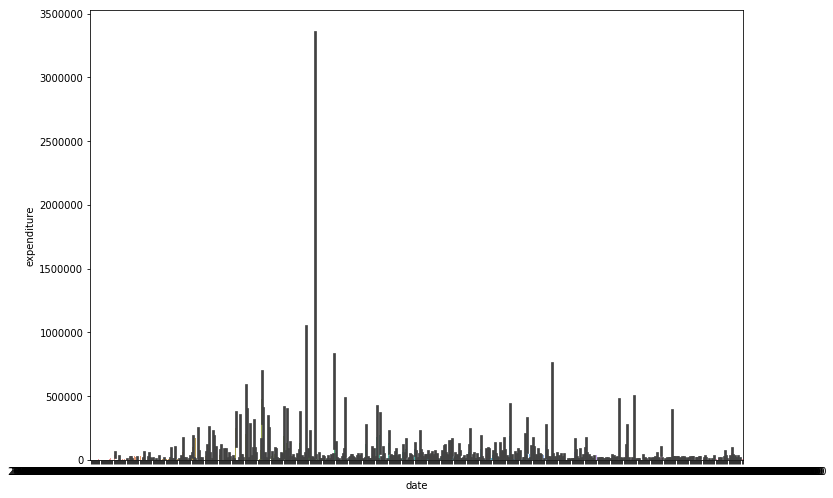

In [20]:
## https://content.pivotal.io/blog/how-data-science-assists-sports
## https://seaborn.pydata.org/generated/seaborn.lineplot.html
# Using seaborn and pyspark dataframes together to create a chart/plot! 
## Do this for contributions over time!

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

total_expenditures_timeseries = sns.barplot(ax=ax, x='date', y='expenditure', data=total_expenditures_dataframe)
total_expenditures_timeseries.get_figure().savefig('/Users/Dan/Desktop/output.png')

## Calculating the Similarity Coefficient of Candidates based on their Contributors
### Overview
In the cells below we calculate the <a href=https://en.wikipedia.org/wiki/Jaccard_index> 'Jaccard Index', or Similarity Coefficient </a>, of candidates based on the identities of their contributors.  This means that we will be able to see those candidates that are more and less similar based on who gives them money.  Scores are between 0 and 1, with one being Identical and 0 being no shared contributors.  This is useful in understanding patterns of giving and opposition, and how committees might be influencing an election across multiple candidates.  

### Method
1. Obtain an RDD of the form (CandidateID, [list of contributor IDs])
2. Obtain the cartesian product of that RDD with itself
3. Calculate the Jaccard Index of each set produced by the cartesian product
    - get the sum of the length of the sets of contributors for each candidate being compared
    - get the length of the union of the sets of contributors to each candidate
    - divide the union of the sets by the total length of the sets
    - multiple by 100
4. Return an RDD of the form (Jaccard Index, (Candidate1ID, Candidate2ID))


### To Do
Weight the jaccard index based on the total number of contributors in each list -- a 1-to-1 similarity between two candidates witha  single contributor each may be valuable and important, but I believe it would be interesting to see the candidates with the greatest similarity amongst the greatest number of contributors.  

Move the similarity_coefficient functions to another notebook, and import that notebook, rather than simply use them here.  We can use this to great effect in other circumstances.

In [21]:
def prep_data(input_rdd, val_key, val_value):
    _prepped_data = (
        input_rdd
        .filter(lambda x: (getattr(x, val_key) != 'None'))
        .map(lambda x: (getattr(x, val_key), [getattr(x, val_value)]))
        .reduceByKey(lambda x, y: x + y)
        .map(lambda x: (x[0], set(x[1])))
    )
    return _prepped_data
    
def rdd_similarity_coefficient_map(input_rdd):
    # Given an RDD of the form [(Identifier, [List of Characteristics])]
    # This function will produce an RDD of the form [(Jaccard Index), Identifier1, Identifier2]
    # based on the cartesian product of the RDD
    _coeff_sim = (
        input_rdd
        # get the cartesian product of the input rdd with itself
        .cartesian(input_rdd)
        # filter out the self * self products
        .filter(lambda x: x[0] != x[1])
        # calculate the Jaccard Index for each result of the cross-product
        # returning a nested tuple of (Jaccard Index, (cand1 id, cand2 id))
        .map(lambda x: (calculate_similarity_coefficient(x[0][1], x[1][1], min_similar=5), (x[0][0], x[1][0])))
    )
    return _coeff_sim
    
def calculate_similarity_coefficient(set_one, set_two, min_similar=None):
    # Function to calculate the Jaccard Index, given two sets
    # Returns the Jaccard Index as a numeric between 0 and 1
    _set_one = set(set_one)
    _set_two = set(set_two)
    _set_one_len = len(_set_one)
    _set_two_len = len(_set_two)
    _set_total_len = _set_one_len + _set_two_len
    _set_intersect_len = len(_set_one.intersection(_set_two))
    if min_similar:
        if _set_intersect_len < min_similar:
            return 0
    _sim_coeff = _set_intersect_len/_set_total_len * 100
    return _sim_coeff

In [22]:
calculate_similarity_coefficient(['1'], ['2'])

0.0

In [23]:
# Calculate the Jaccard similarity for each candidate the committee who has spent on that candidate
rdd_similarity_coefficient_map(prep_data(total_expenditures_rdd, 'cand_id', 'spe_id')).sortByKey(False).collect()

[(42.857142857142854, ('H6FL02190', 'H6FL02208')),
 (42.857142857142854, ('H6FL02208', 'H6FL02190')),
 (37.93103448275862, ('H4FL26038', 'H0IL10302')),
 (37.93103448275862, ('H0IL10302', 'H4FL26038')),
 (35.714285714285715, ('H6MN02149', 'H4NV04017')),
 (35.714285714285715, ('H4NV04017', 'H6MN02149')),
 (35.294117647058826, ('P60008059', 'P60008521')),
 (35.294117647058826, ('P60008521', 'P60008059')),
 (33.33333333333333, ('H0TX23086', 'H2TX23124')),
 (33.33333333333333, ('H4MN08083', 'H2IA01055')),
 (33.33333333333333, ('H2TX23124', 'H0TX23086')),
 (33.33333333333333, ('P60008521', 'P60003670')),
 (33.33333333333333, ('P60003670', 'P60008521')),
 (33.33333333333333, ('H8MN03077', 'H0CA19173')),
 (33.33333333333333, ('H2NV04045', 'H2IA01055')),
 (33.33333333333333, ('H4ME02200', 'H4NV04017')),
 (33.33333333333333, ('H0CA19173', 'H8MN03077')),
 (33.33333333333333, ('H2IA01055', 'H4MN08083')),
 (33.33333333333333, ('H2IA01055', 'H2NV04045')),
 (33.33333333333333, ('H4NV04017', 'H4ME0220